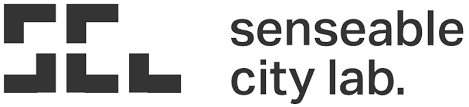

#Setup Google colab
Mount your drive. This is necessary to give colab acces to the files in your personal drive, install, and load packages


In [ ]:
#this block is going to allow the notebook to connect to your google drive so you can interact with it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next we need to make some bash commands to install packages that we are gonna use today that are not preloaded in google colab. In colab you can regocnize bash commands by the ! before the code

In [ ]:
# Install non default packages in this notebook environment
# Unfornutately you need to run this cell everytime you start a new session
!pip install geopandas
!pip install osmnx
!pip install folium
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.8 MB/s eta 0:00:00


Now that we installed all the packages that are not preloaded we are gonna import all the installed packages into our environment. Import in this case just means you are telling colab to 'activate' these packages for this session

In [ ]:
#Block 2
#this block of code is where we get the infrastructure for the notebook set up, by calling libraries
#these are the libraries needed to load the data and put it into a usable format
import csv
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import os

#these libraries will map and graph the data
import seaborn as sns
from datetime import datetime
from shapely.geometry import Point
import folium
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

Now that we have loaded our packages we can check what our current working directory is. Or the file that this code is operating from. This is necessary to know the filepaths for external data you are going to be loading in.

In [ ]:
#check working directory
os.getcwd()

'/content'

Our current working directory is the folder /content. Now we set a new working directory to simplify the input file paths and to replicate the file structure from the provided ZIP file that you uploaded to your home folder of your personal google drive

In [ ]:
#set working directory
os.chdir('/content/drive/My Drive/Colab Summer school')
#Check your working directory again
os.getcwd()

'/content/drive/My Drive/Colab Summer school'

Now that we have set up our colab, installed the right packages and have activated the packages that we will need we can start by parsing our data.

#Import data from the meteo tracker, octopus, or kestrel
in this section we will load our data into our environment using one of the three dataloaders depending on which sensor data you want to load in. # this is the file path to your CSV. You need to specify the file path from the working directory (your homebase) to the location of this file
in this case the file is in the /data folder

**Run this cell for octopus data analysis**

In [ ]:
# Read the raw data from a CSV file into a DataFrame

directory_path = 'data/sensor_measurements/octopus'


#create a custom function to load the data and do some basic preprocessing

def dataloader_octo(directory_path):

    #  empty ist to store individual DataFrames
    dfs = []

    # iterate over all files in the directory
    # this is necessary as the octopus sensor makes a new csv after 200 measurements
    for filename in os.listdir(directory_path):

        # construct the full file path
        file_path = os.path.join(directory_path, filename)


        # read all the files that end with .csv in this directory. (case insensitive)
        if filename.lower().endswith('.csv'):
            # read the CSV file
            df = pd.read_csv(file_path)

            # shorten coordinate names and remove capitalization for good practice
            df = df.rename(columns={
                'Latitude': 'lat',
                'Longitude': 'lon',
                'Temperature': 'temperature',
                'Humidity': 'humidity',
                'Timestamp': 'timestamp'
            })

            # drop all the columns with pm measurements as we have not configured the device to do pm measurements
            df.drop(df.iloc[:, 5:], inplace=True, axis=1)

            # add the dataframe for every loop in the for loop to the same list
            dfs.append(df)
    if len(dfs) == 1:
        return dfs[0]
    # combine all of then into a single dataframe
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

# call the function made above to load the data
df = dataloader_octo(directory_path)
# print the first few rows to verify the headers and print shape
print(df.head(), 'dataframe rows and columns:', df.shape)


            timestamp       lat       lon  temperature  humidity
0   2024-8-23 14:21:7  52.37978  4.916818        26.55     62.49
1  2024-8-23 14:21:12  52.37978  4.916818        26.66     68.65
2  2024-8-23 14:21:17  52.37978  4.916818        26.67     55.37
3  2024-8-23 14:21:22  52.37978  4.916818        26.70     51.32
4  2024-8-23 14:21:27  52.37978  4.916818        26.74     50.10 dataframe rows and columns: (178, 5)


In the following cell you will find  the dataloader for the meotracker censor it has the same basic structure as the octopus loader. However there is one extra line of code that removes all the columns after 5. (Note that in programming counting generally starts at 0, so 0 1 2 3 4 5)

**Run this cell for meteotracker data analysis**

In [ ]:
#Meteotracker dataloader
file_path ='data/sensor_measurements/meteotracker.csv'

def dataloader_met(file_path):
  # Read the CSV file
  df = pd.read_csv(file_path)
  # Remove all columns between column from index 5 onward you can comment out the line below to check te full dataframe
  df.drop(df.iloc[:, 5:], inplace=True, axis=1)

  #rename columns to get rid of symbols and caps
  df.rename(columns={'Temp[°C]': 'temperature',
                        'Hum[%]': 'humidity',
                        'Time': 'timestamp',
                        'Lat':'lat',
                        'Lon':'lon'}, inplace=True)

  return df

df2 = dataloader_met(file_path)
# Print the first few rows to verify
print(df2.head())

            timestamp       lat       lon  temperature  humidity
2  2024-8-23 14:21:17  52.37978  4.916818        26.67     55.37
3  2024-8-23 14:21:22  52.37978  4.916818        26.70     51.32
4  2024-8-23 14:21:27  52.37978  4.916818        26.74     50.10
5  2024-8-23 14:21:32  52.37978  4.916818        26.81     49.15
6  2024-8-23 14:21:37  52.37978  4.916818        26.82     49.07


In the next cell is a dataloader for the kestral sensor. Note that this is a stationary sensor so in this case the spatial analysis is less interesting and to focus is more on the time series.


**Run this cell for kestral data analysis**

In [ ]:
# Dataloader kestral sensor
file_path = 'data/sensor_measurements/kestral.csv' # replace with correct filepath

def dataloader_kestral(file_path):

  # Read the CSV file
  df = pd.read_csv(file_path, skiprows = 3)

  # Remove the first row beacuse it contains the unit information and not an actual measurement value
  df = df.drop(index=0).reset_index(drop=True)

  # Remove all columns between column from index 5 onward you can comment out the line below to check te full dataframe
  df.drop(df.iloc[:, 11:], inplace=True, axis=1)

  return df

df3 = dataloader_kestral(file_path)
# Print the first fe rows to verify
print(df3.head())



      FORMATTED DATE_TIME Temperature Wet Bulb Temp Globe Temperature  \
0  2024-08-22 04:21:05 PM        24.8          17.2              24.6   
1  2024-08-22 04:21:10 PM        25.3          17.6              24.6   
2  2024-08-22 04:21:15 PM        25.7          17.9              24.6   
3  2024-08-22 04:21:20 PM        26.0          18.0              24.6   
4  2024-08-22 04:21:25 PM        26.1          18.0              24.6   

  Relative Humidity Barometric Pressure Altitude Station Pressure Wind Speed  \
0              47.3              1009.2       32           1009.2        0.0   
1              47.1              1009.2       32           1009.1        9.7   
2              46.8              1009.2       32           1009.2       10.5   
3              46.4              1009.2       32           1009.2        6.1   
4              45.9              1009.2       32           1009.2        4.5   

  Heat Index Dew Point  
0       23.9      12.8  
1       24.5      13.2  
2    

#Data preprocessing
This step we do more advanced preprocessing to make sure that the data we do our analysis on is valid. This is especially important when using a community homemade sensor like the octopus. In commercial products like the meteotracker or the kestrel this is less necessary becuase of the more rigourus quality control.

1. The first step is to handle missing values in your dataframe. There are two options for this. You either remove the whole row or you fill the row with values based on the values around it. In this case because of the relatively limited amount of data we fill the rows with the value of the closest neighbour
2. The second step is to deal with outliers. Cheaper sensors that are often used in community sensing projects can have the occasional faulty measurement now these faulty measurement values are often extremely different from the normal data distribution and are therefore called outliers. In the second block we calculate the Z-score which is a measure to quantify the level of difference from a datapoint to the general data distribution. In this case we filter out all values with a Z score of with an absolute value of |3|

In [ ]:
# code to remove the first fifty rows from a dataframe you can edit it to remove any number of rows you want.
# depends on how long it took to set it up and go outside

df = df.iloc[50:].reset_index(drop=True)


In [ ]:
# Handling missing values by fillin in missing values with the closest neighbour
df["temperature"].fillna(method="ffill", inplace=True)
df["humidity"].fillna(method="ffill", inplace=True)
print(df.head())

            timestamp       lat       lon  temperature  humidity
0   2024-8-23 14:21:7  52.37978  4.916818        26.55     62.49
1  2024-8-23 14:21:12  52.37978  4.916818        26.66     68.65
2  2024-8-23 14:21:17  52.37978  4.916818        26.67     55.37
3  2024-8-23 14:21:22  52.37978  4.916818        26.70     51.32
4  2024-8-23 14:21:27  52.37978  4.916818        26.74     50.10


<ipython-input-16-7b0a736062f3>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["temperature"].fillna(method="ffill", inplace=True)
<ipython-input-16-7b0a736062f3>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["humidity"].fillna(method="ffill", inplace=True)


In [ ]:
# Z score calculation and removal of values with Z score above 3 if you have included other columns copy the code and fill in that column name in the brackets
z_scores_temp = (df["temperature"] - df["temperature"].mean()) / df["temperature"].std()
z_scores_humidity = (df["humidity"] - df["humidity"].mean()) / df["humidity"].std()
df = df[(z_scores_temp.abs() < 3) & (z_scores_humidity.abs() < 3)] # threshold used is ±3
print(df.head())

            timestamp       lat       lon  temperature  humidity
2  2024-8-23 14:21:17  52.37978  4.916818        26.67     55.37
3  2024-8-23 14:21:22  52.37978  4.916818        26.70     51.32
4  2024-8-23 14:21:27  52.37978  4.916818        26.74     50.10
5  2024-8-23 14:21:32  52.37978  4.916818        26.81     49.15
6  2024-8-23 14:21:37  52.37978  4.916818        26.82     49.07


# First analysis plotting
In this section we will create time series plots of your temperature and humidity measurements. Time series plots are  a good way to visualise the sequential distribution of your data. You can also already start thinking about the possible reasons for fluctuations in temperature or humidity over time.
1. the first cell will be the temperature plot
2. the second cell will contain the humidity plot
3. If you want to make this plot for other measurements copy the code replace the column name 'temperature' with the variable that you want to plot


In [ ]:
# Copy dataframe and set the timestamp as index for the time series plot
# Creating the copy is necessary because the spatial packages (Folium and geopandas) do not work well with timestamp as index
df_copy = df.copy()
df_copy['timestamp'] = pd.to_datetime(df['timestamp'])#, format='%m/%d/%y %H:%M', errors='coerce')
df_copy.set_index("timestamp", inplace=True)

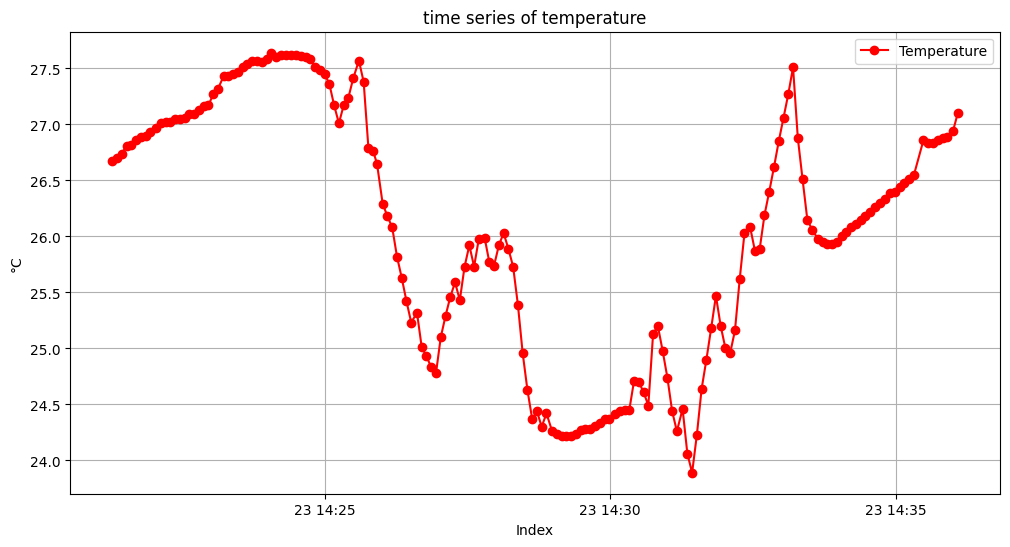

In [ ]:
# Plot Temperature

plt.figure(figsize=(12, 6))
plt.plot(df_copy.index, df['temperature'], label='Temperature', color='red', marker='o')
plt.xlabel('Index')
plt.ylabel('°C')
plt.title('time series of temperature')
plt.legend()
plt.grid(True)
plt.show()

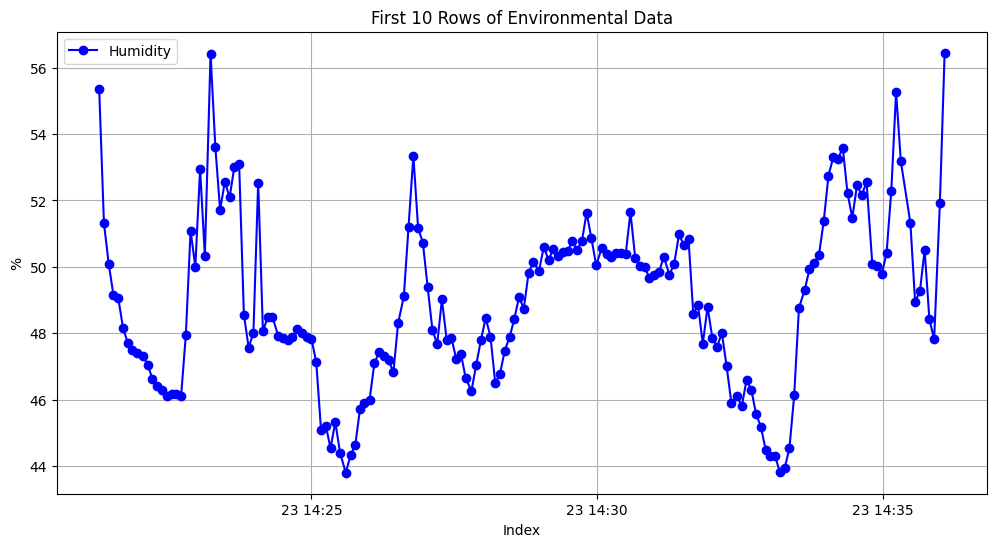

In [ ]:
# Plot Humidity

plt.figure(figsize=(12, 6))
plt.plot(df_copy.index, df['humidity'], label='Humidity', color='blue', marker='o')
plt.xlabel('Index')
plt.ylabel('%')
plt.title('First 10 Rows of Environmental Data')
plt.legend()
plt.grid(True)
plt.show()

#Second analysis mapping
In this section we will put your measurements onto a map. In order to do this we need to change our normal dataframe to a geodataframe. This means that we are adding a spatial component to our dataframe. You could have noticed to columns lat and lon, these are the coordinates of each individual observation and will be used to transform our data from a normal dataframe into a geodataframe.

1. Transform dataframe to geodataframe by specifying lat lon as our spatial component
2. Plotting our measurement on a open street map background map.
3. Specify a colour scheme for the temperature column

The last part will give you an insight in the spatial distribution of your measurements.
For more information on the gdf.explore() function see this page: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html

colour schemes see this page: https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [ ]:
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"  # WGS 84 - meters
)

# Change the projection to the standart projection used by the dutch government
gdf['geometry'] = gdf['geometry'].to_crs(epsg = '28992')

#Plot geodataframe on interactive map
gdf.explore(column = 'temperature', legend = True, cmap = 'YlOrRd') # You can change the YlOrRd to one of the colour schemes on the linked page above

In [ ]:
#check the structure of the created geo dataframe
gdf.head()

,timestamp,lat,lon,temperature,humidity,geometry
2,2024-8-23 14:21:17,52.37978,4.916818,26.67,55.37,POINT (122971.799 488094.327)
3,2024-8-23 14:21:22,52.37978,4.916818,26.70,51.32,POINT (122971.799 488094.327)
4,2024-8-23 14:21:27,52.37978,4.916818,26.74,50.10,POINT (122971.799 488094.327)
5,2024-8-23 14:21:32,52.37978,4.916818,26.81,49.15,POINT (122971.799 488094.327)
6,2024-8-23 14:21:37,52.37978,4.916818,26.82,49.07,POINT (122971.799 488094.327)


# Spatial operations
In this step we will combine dirrent spatial data to create one larger dataset. We have prepared a land use dataset for you. We are going to combine this land use dataset with our measurement points. We perform this operation so that we can look at the correlations between different land uses and temperature.

1. In the first cell we will load in our landuse dataset. Change the projection and map it  
2. In the second cell we will generate a 100m buffer around each observation
3. In the third cell we will calculate the ratio of each land use class in the respective buffer
4. In the fourth cell we will save this new combined geodataframe.

For extra geo-data you can look at the Amsterdam Municipality geo-data portal: https://maps.amsterdam.nl/open_geodata/

If you get data from here upload it into the geo-data folder and you can access it the same way as the landuse map and look the correlation of more specific features. You could for example load in the tree database of the municipality and look and the correlation of the number of trees whithin the buffer area and the temperature. Tip: use the geopandas spatial join function for this https://geopandas.org/en/stable/gallery/spatial_joins.html

Here is also a link with the maps they have: https://maps.amsterdam.nl/


<Axes: >

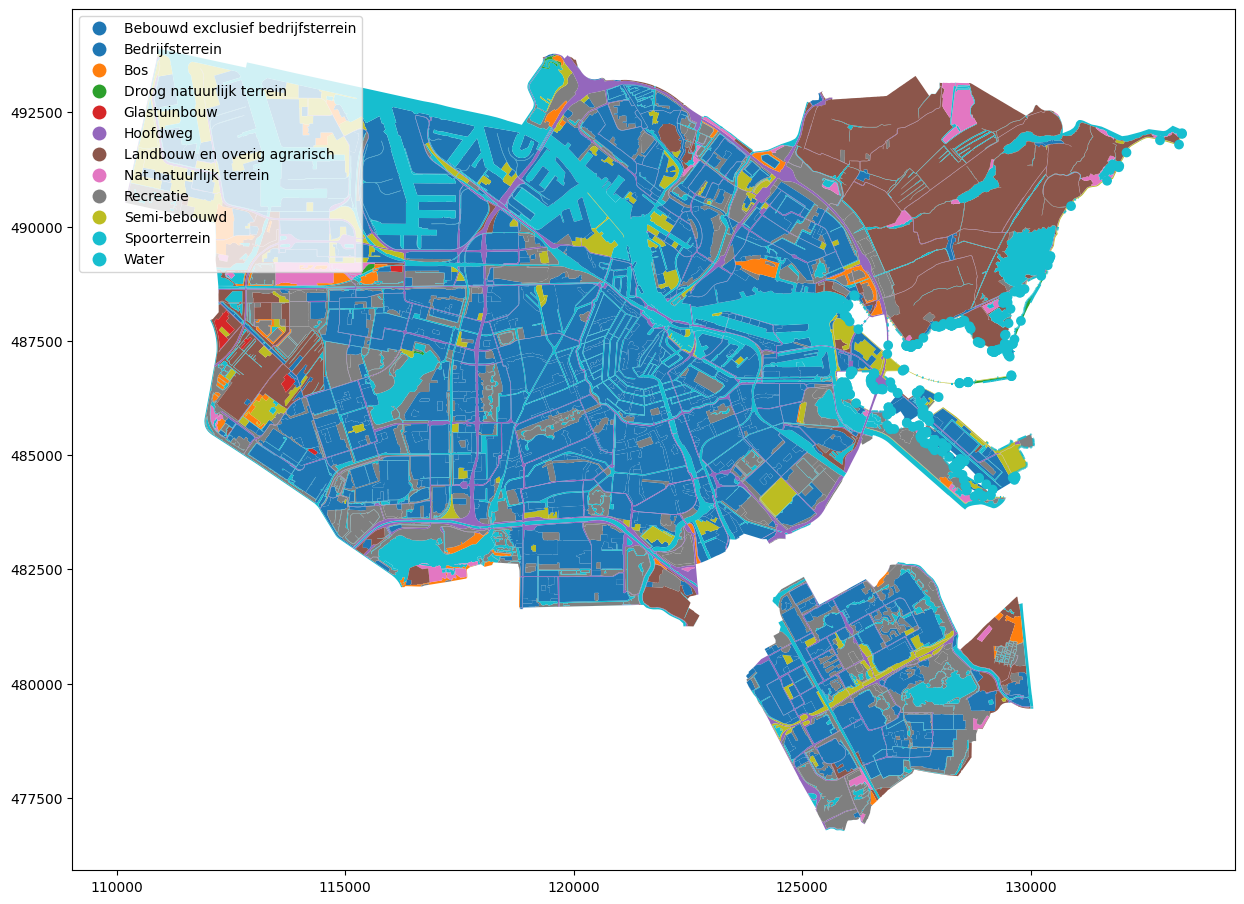

In [ ]:
# read file with geopandas
land_use = gpd.read_file('data/geo-data/landuse')

# Ensure same projection method as our measurements
land_use.to_crs(epsg = '28992', inplace = True)
# Plot our landuse map for Amsterdam
land_use.plot(column = 'bodemgebruik', legend = True, figsize = (15,15))


<Axes: >

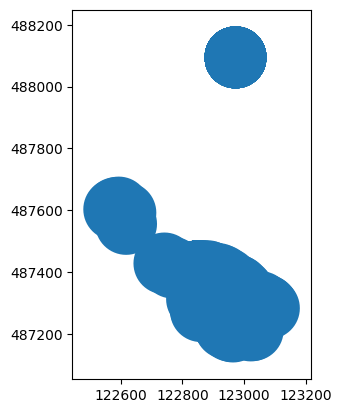

In [ ]:
# Create buffer and plot
buffer_distance = 100
gdf['geometry'] = gdf['geometry'].buffer(buffer_distance)
gdf.plot()


In [ ]:
#check the structure of your newly created buffer dataframe not the the geometry changed from 'POINT' to 'POLYGON'
gdf.head()

,timestamp,lat,lon,temperature,humidity,geometry
0,2024-8-23 14:21:7,52.37978,4.916818,26.55,62.49,"POLYGON ((123071.799 488094.327, 123071.317 48..."
1,2024-8-23 14:21:12,52.37978,4.916818,26.66,68.65,"POLYGON ((123071.799 488094.327, 123071.317 48..."
2,2024-8-23 14:21:17,52.37978,4.916818,26.67,55.37,"POLYGON ((123071.799 488094.327, 123071.317 48..."
3,2024-8-23 14:21:22,52.37978,4.916818,26.70,51.32,"POLYGON ((123071.799 488094.327, 123071.317 48..."
4,2024-8-23 14:21:27,52.37978,4.916818,26.74,50.10,"POLYGON ((123071.799 488094.327, 123071.317 48..."


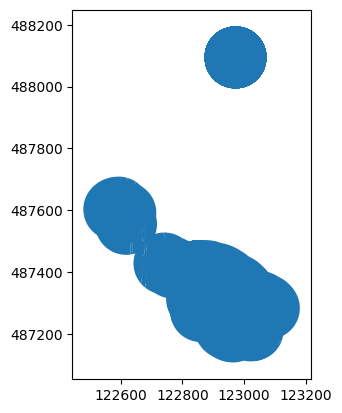

In [ ]:
# calculate buffer areas
gdf['area'] = gdf.geometry.area

# perform overlay
union = gpd.overlay(df1=gdf, df2=land_use[['bodemgebruik', 'geometry']], how='intersection')
union["intersection_area"] = union.geometry.area

# Calculate percentages
union["class_percentage"] = union.apply(lambda x: (x.intersection_area / x.area), axis=1)
union.plot()

# Pivot the result to get percentages for each land use class
pivoted = union.pivot_table(index="timestamp", columns='bodemgebruik', values="class_percentage", aggfunc='sum', fill_value=0)

# Rename columns to avoid conflicts
pivoted.columns = [f'{col}_percent' for col in pivoted.columns]

# Reset index to merge with original GeoDataFrame
pivoted = pivoted.reset_index()

# Merge the pivoted result back to the original GeoDataFrame
gdf = gdf.merge(pivoted, on='timestamp', how='left')

# Fill NaN values with 0 for land use percentages
for col in pivoted.columns:
    if col.startswith('landuse_'):
        gdf[col] = gdf[col].fillna(0)

In [ ]:
# check wat landuse columns got added to the gdf with measurements.
print(gdf.head(), 'dataframe shape:', gdf.shape)

            timestamp       lat       lon  temperature  humidity  \
0   2024-8-23 14:21:7  52.37978  4.916818        26.55     62.49   
1  2024-8-23 14:21:12  52.37978  4.916818        26.66     68.65   
2  2024-8-23 14:21:17  52.37978  4.916818        26.67     55.37   
3  2024-8-23 14:21:22  52.37978  4.916818        26.70     51.32   
4  2024-8-23 14:21:27  52.37978  4.916818        26.74     50.10   

                                            geometry          area  \
0  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
1  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
2  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
3  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
4  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   

   residential  road  light_residential  Spoorterrein_percent_x     water  \
0          0.0   0.0           0.047708                     0.0  0.952292   
1          0.0  

In [ ]:
# rename columns and head dataframe comment out the columns that you did not see in the in gdf printed in the last cell
gdf.rename(columns={'Water_percent': 'water',
                    'Bebouwd exclusief bedrijfsterrein_percent': 'residential',
                    'Bedrijfsterrein_percent': 'commercial',
                    'Hoofdweg_percent': 'road',
                    'Recreatie_percent': 'recreational',
                    'Semi-bebouwd_percent': 'light_residential',
                    }, inplace=True)
#Check dataframe with new columns columns with the percentage of landuse inside each buffer polygon have been added
print(gdf.head(), 'gdf shape:', gdf.shape)


            timestamp       lat       lon  temperature  humidity  \
0   2024-8-23 14:21:7  52.37978  4.916818        26.55     62.49   
1  2024-8-23 14:21:12  52.37978  4.916818        26.66     68.65   
2  2024-8-23 14:21:17  52.37978  4.916818        26.67     55.37   
3  2024-8-23 14:21:22  52.37978  4.916818        26.70     51.32   
4  2024-8-23 14:21:27  52.37978  4.916818        26.74     50.10   

                                            geometry          area  \
0  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
1  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
2  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
3  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   
4  POLYGON ((123071.799 488094.327, 123071.317 48...  31365.484905   

   residential  road  light_residential  Spoorterrein_percent     water  
0          0.0   0.0           0.047708                   0.0  0.952292  
1          0.0   0.0  

# Correlation analysis
Now that we have one big dataframe that include our own temperature measures and a range of land use classes we can start to explore the correlations between different land use classes and temperature.

In this section I will provide you with the code for two scatter plots and a function to calculate some basic statistics of the data. I you want to plot more of the variables against temperature you can copy the code into a new cell and chang the column that is plotted in the X-axis.

1. The first cell will contain the basic statistics function
2. Cell two and three will have one scatter plot each

In [ ]:
# First we will calcualte the basic statistics
def base_statistics(gdf):
    # Calculate statistics
    stats = gdf.describe().loc[['mean', '50%', 'std', 'max', 'min']].rename(index={'50%': 'median'})
    return stats

stats = base_statistics(gdf)
print(stats)


              lat       lon  temperature   humidity          area  \
mean    52.362098  4.892978    27.704459  47.678344  3.136548e+04   
median  52.360705  4.897450    27.900000  47.000000  3.136548e+04   
std      0.005729  0.025457     0.501734   2.456336  7.287571e-12   
max     52.373849  4.925824    28.400000  57.000000  3.136548e+04   
min     52.354614  4.843404    26.400000  44.000000  3.136548e+04   

        residential  commercial      road  recreational     water  
mean       0.609671    0.035203  0.054779      0.164919  0.135427  
median     0.618681    0.000000  0.000000      0.000000  0.125055  
std        0.221387    0.113845  0.073522      0.229825  0.097042  
max        1.000000    0.702172  0.340942      0.838884  0.472483  
min        0.000078    0.000000  0.000000      0.000000  0.000000  


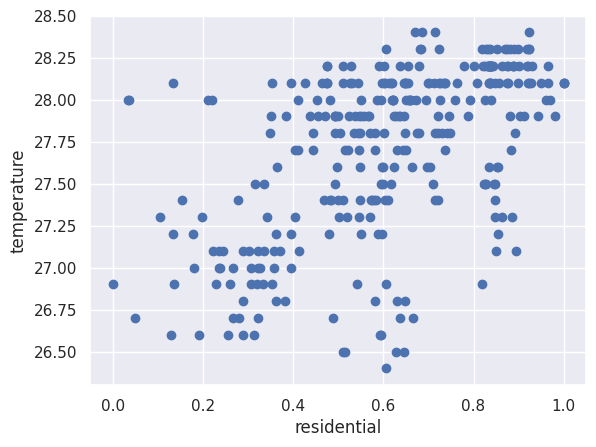

In [ ]:
#temperature correlations
# Set the style of the plot to seaborne for readability
sns.set()
# plot temperature against one or several of your chosen street features from OSM replace the residential feature with a feature of your choice
plt.scatter(y= gdf['temperature'], x = gdf['residential'])
plt.xlabel('residential')
plt.ylabel('temperature')
plt.show()


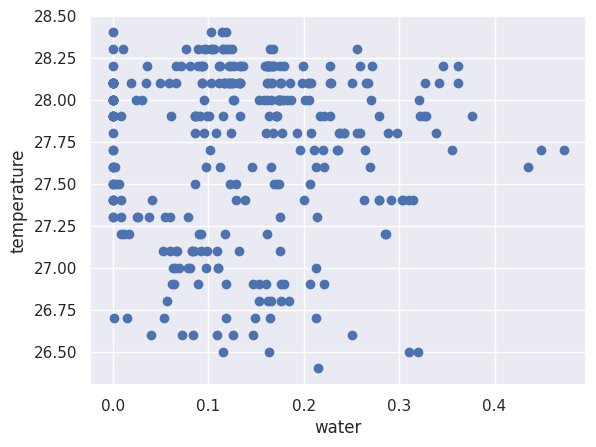

In [ ]:
#temperature correlations
# Set the style of the plot to seaborne for readability
sns.set()
# plot temperature against one or several of your chosen street features from OSM replace the residential feature with a feature of your choice
plt.scatter(y= gdf['temperature'], x = gdf['water'])
plt.xlabel('water')
plt.ylabel('temperature')
plt.show()

# Advanced analysis 1: Introduction to machine learning

In this section you can start with a short introduction into machine learing techniques to predict temperature based on urban morphological features. This section is not required. If you have any questions about this ask Michiel or Titus.

In this section we will introduce two models. the first model is a simple linear regression model. The basic formula for this is y = ax + b. y is the target variable here (temperature) and the feature you are using the predict y. a is the coeffecient or the degree of imporantance of feature x on outcome y. b is bias introduced into the model. In our case we are doing a multiple linear regression, meaning that there is more then 1 input feature. This is typically noted down as follows. Here $beta$ is the coeffecient for each feature $X1$ until $Xn$.

  $Y=β
0
​
 +β
1
​
 X
1
​
 +β
2
​
 X
2
​
 +⋯+β
n
​
 X
n
​
 +ϵ$


 In the _train_test_split() funtion you can change the input features for the regression.

 Secondly, in the next section a more complex xgboost model can be found. This is a variation of a gradient boosting tree. This model is highly complex and will overfit on the small dataset that we have collected. This means that it will perform well with a high level of accuracy on the collected data today. But it most likely wont be generalizable to data collected under different circumstances.

In [ ]:
# We need to import some new packages specific to machine learning
# Here we are using the sklearn package which is the most commonly used package for machine learning in python
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the dataset in 80% training data and 20% test data
# the training data will be used to teach the model the relationship between the input variables and the dependent variable (temperature)
# the test data is to check how well the model learned this relation ship
def _train_test_split(df):
    #define dependent and independ variable
    X = df.drop(['temperature', 'timestamp', 'lat', 'lon', 'geometry', 'area'
            ], axis = 1)
    y = df['temperature']
    #train test split into standart 80 train 20 test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

# in this funciton we call the model train it on the training data en run it on the test data
# We have included two evaluation metrics r2, the higher the better, and MSE, in this case the lower the better

def linear_regression_train_test(df):

    X_train, X_test, y_train, y_test = _train_test_split(df)
    # linear regression


    model = LinearRegression().fit(X_train, y_train)

    #run model on test set
    y_pred = model.predict(X_test)
    coefficients = model.coef_
    coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('Test MSE:', mse, 'r2:', r2, 'coefficients:', coefficients_df)

    return y_pred


linear_regression_train_test(gdf)

Test MSE: 0.06598026351323193 r2: 0.7507417849612442 coefficients:         Feature   Coefficient
0      humidity -1.796360e-01
1   residential  4.182900e+12
2    commercial  4.182900e+12
3          road  4.182900e+12
4  recreational  4.182900e+12
5         water  4.182900e+12


array([27.72900391, 27.72460938, 28.05615234, 26.69042969, 28.046875  ,
       28.1171875 , 27.48242188, 27.51123047, 28.02783203, 27.8984375 ,
       27.74462891, 28.04199219, 27.83154297, 27.27636719, 27.18408203,
       28.12011719, 27.16552734, 27.77978516, 27.53027344, 28.09521484,
       27.21777344, 27.29199219, 27.23730469, 27.85351562, 27.88818359,
       27.51171875, 28.29931641, 28.03125   , 27.90917969, 28.13720703,
       28.01464844, 27.36962891, 27.89501953, 28.09472656, 28.03271484,
       27.81542969, 28.02294922, 27.31933594, 26.77929688, 28.16357422,
       27.39111328, 27.37109375, 26.99658203, 27.64697266, 27.54931641,
       27.79492188, 27.94824219, 28.25927734, 27.64404297, 27.35839844,
       28.04345703, 28.03759766, 28.14746094, 27.78613281, 27.97949219,
       27.27246094, 28.02490234, 27.3671875 , 27.1953125 , 26.43652344,
       27.90332031, 27.74267578, 28.18017578])

# Advanced machine learning

In this cell we are doing a more advanced form of machine learning. Xgboost is one the most popular and versatile machine learning models. It is widely used in both industry and research. The basic principle of machine learning is to balance the amount of variance and bias in your model to generate accurate predictions. When the bias is to high it means that your model is to simpel to capture the complex underlying patterns in the data. On the opposite side when the variance in the model is to high your model will overfit on the training data and perform poorly on unseen data.

That is why in general to balance the bias and variance we perform hyper parameter tuning. In the corresponding function we input a grid of model parameters that influence the amount of variance/bias in the model. We then run different combinations of these parameters and asses its performance with a loss function. The best performing set of parameters is then saved and used on the test set.

This model is included more as an example of the more advanced analysis methods that are possible. You are not expected to use this. Again if you have any questions ask Michiel or Titus

Best parameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.7}
Test MSE: 0.09419995888986805 r2: 0.6441342856276423


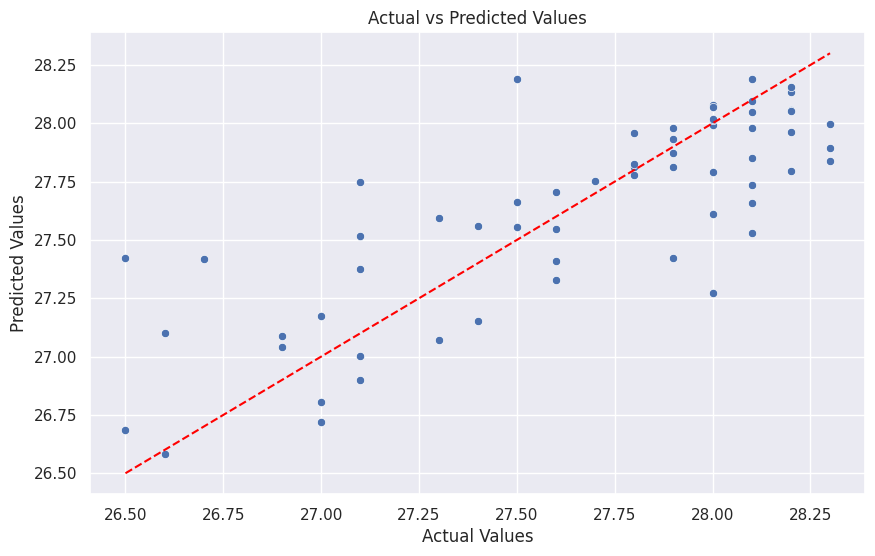

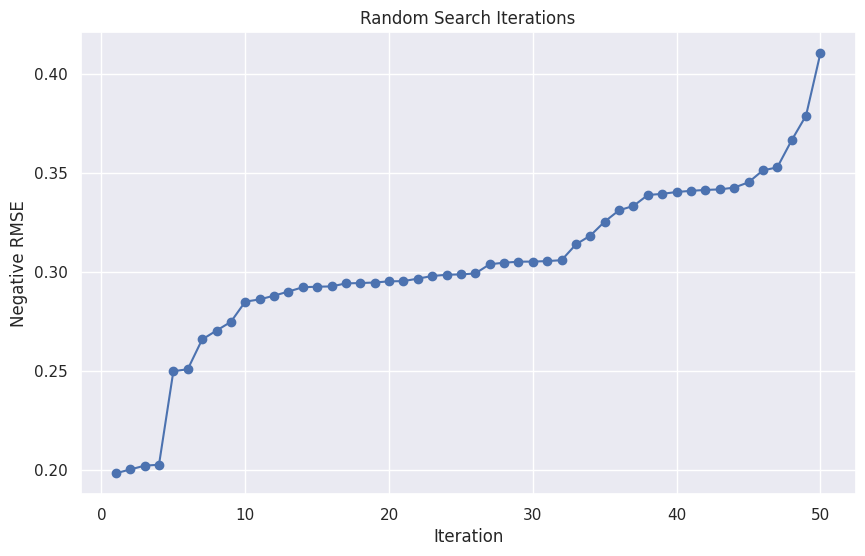

In [ ]:

#Xgboost and chill
# import xgboost package
import  xgboost as xgb

class xgb_regression():
  def __init__(self):
      pass

  # as an extra you could a _preprocess_data function to do some data handling or feature engineering

  def _train_test_split(self, df):

    # define dependent and independ variables
    X = df.drop(['temperature', 'timestamp', 'lat', 'lon', 'geometry', 'area', 'humidity'
            ], axis = 1)
    y = df['temperature']
    # train test split into standart 80 train 20 test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

  def _hyper_param_tuning(self, X_train, y_train):
    # xgboost hyper parameter grid
    xgb_params = {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 2, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5, 6, 7, 8, 10],
        'reg_alpha': [0, 0.01, 0.1, 1, 10],
        'reg_lambda': [0, 0.01, 0.1, 1, 10],
    }

    # select best model composition
    grid_search = RandomizedSearchCV(xgb.XGBRegressor(), xgb_params, scoring='neg_mean_absolute_error', n_iter= 50, cv = 5).fit(X_train, y_train)

    # print the best hyperparameters parameters found by GridSearchCV
    print('Best parameters:', grid_search.best_params_)
    best_xgboost = grid_search.best_estimator_ # save best model
    cv_results = grid_search.cv_results_

    return best_xgboost, cv_results


  def _evaluate_model(self, best_xgboost, X_test, y_test):
    # Evaluate the model on the test set
    y_pred = best_xgboost.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print('Test MSE:', mse, 'r2:', r2)

    return y_pred

  def _plot_results(self, y_test, y_pred, cv_results):
    # plot the predicted vs actual values visualize model accuracy
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.show()

    # visualize loss function for different intirations of the gridsearch
    results = pd.DataFrame(cv_results)
    results.sort_values(by='rank_test_score', inplace=True)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(results['mean_test_score']) + 1), -results['mean_test_score'], marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Negative RMSE')
    plt.title('Random Search Iterations')
    plt.show()

  # optional _preprocess_data function would need to be integrated into this execute pipeline function
  def execute(self, df):
      # execute the full pipeline
      X_train, X_test, y_train, y_test = self._train_test_split(df)
      best_xgboost, cv_results = self._hyper_param_tuning(X_train, y_train)
      y_pred = self._evaluate_model(best_xgboost, X_test, y_test)
      self._plot_results(y_test, y_pred, cv_results)

xgb_reg = xgb_regression()
xgb_reg.execute(gdf)

#Advanced analysis 2: Introduction to computer vision



In [ ]:
# import additional packages and load in the pretrained model weights
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# load the Mask2Former model fine-tuned on Cityscapes semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/77.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

In [ ]:


# directory containing your images
image_directory = 'data/images'

# output dataframe with the ratio of each class visible in the picture
output_csv = 'data/segmentation_results.csv'

# get the id2label mapping from the model config to give the correct labels to each class id
id2label = model.config.id2label

# empty list to store results of the segmentation
results = []

# Process each image in the directory
for image_filename in os.listdir(image_directory):
    if image_filename.endswith(('.jpg', '.jpeg', '.png')): # deal with different formats make sure the pictures in the directory are one these three
        image_path = os.path.join(image_directory, image_filename)
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, return_tensors="pt") # in order for the model to be able to interpet the picture it has to be trasformed into a tensor which is a specific sort of data array

        with torch.no_grad():
            outputs = model(**inputs)

        # post-process to get semantic segmentation map with the processor loaded in the previous cell
        predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

        # convert the tensor to a numpy array to count pixels
        semantic_map_np = predicted_semantic_map.numpy()

        # calculate the percentage of each class by counting the pixels of each class divided by the total amount of pixels in the mask
        class_counts = np.bincount(semantic_map_np.flatten(), minlength=len(id2label))
        total_pixels = semantic_map_np.size
        class_percentages = (class_counts / total_pixels)

        # store the results for this image
        result = {'image': image_filename}
        for class_id, percentage in enumerate(class_percentages):
            class_label = id2label.get(class_id, f'class_{class_id}')
            result[class_label] = percentage

        # same as in the dataloader we put each iteration of the for loop going trough the images in the directory into a list
        results.append(result)

# Convert results to a DataFrame and save as CSV
df_results = pd.DataFrame(results)
df_results.to_csv(output_csv, index=False)

print(df_results.head())

   image      road  sidewalk  building      wall     fence      pole  \
0  9.jpg  0.394838   0.00804  0.196117  0.001046  0.002696  0.002987   

   traffic light  traffic sign  vegetation  terrain       sky    person  \
0       0.001432       0.00453    0.004737      0.0  0.317231  0.000839   

      rider       car     truck  bus     train  motorcycle   bicycle  
0  0.010307  0.053005  0.001275  0.0  0.000142         0.0  0.000779  


Now that we have a dataframe with the ratio of each class, we are going to visualize the segmentation mask.


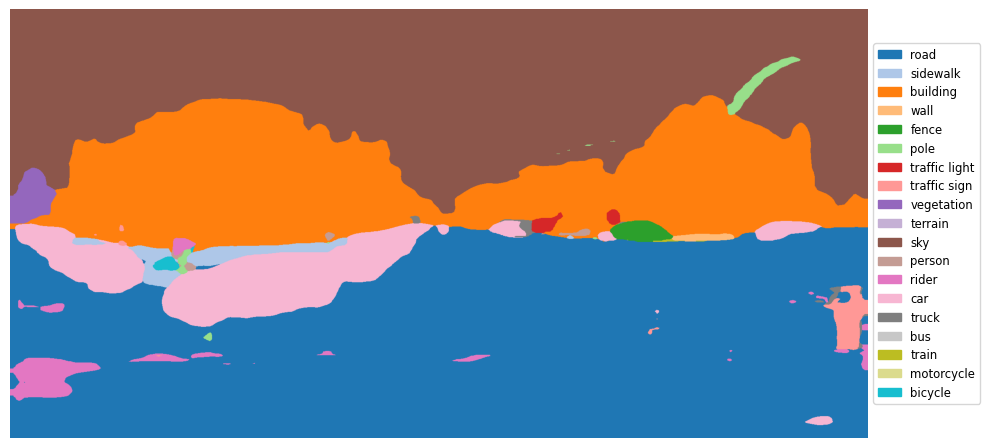

In [ ]:
import matplotlib.patches as mpatches

semantic_map_np = predicted_semantic_map.numpy()

# get the number of classes
num_classes = len(id2label)

# create a color map
color_map = plt.get_cmap('tab20')

# create a colored image for visualization
colored_semantic_map = color_map(semantic_map_np / num_classes)
colored_semantic_map = (colored_semantic_map[:, :, :3] * 255).astype(np.uint8)

# create a PIL image from the colored numpy array
colored_semantic_image = Image.fromarray(colored_semantic_map)

# display the colored segmentation mask
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(colored_semantic_image)
ax.axis('off')

# create a legend for readabiltiy
legend_elements = [mpatches.Patch(color=color_map(i / num_classes), label=id2label[i]) for i in range(num_classes)]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout()
plt.show()